In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# 2. Linear regression

## Simple linear regression (GHV Chapters 6-9)

***Start of Lecture 4, 2025.01.20 (recorded 2025.01.18)***

### Today

- Sample from a simple linear regression model

- Fit a simple linear regression model

- Investigate distributions of parameter estimates

- Primary reference: GHV Chapter 6

### The model

$$
y_i = a + b x_i + \epsilon_i,\qquad \epsilon_i\sim N(0, \sigma^2)\qquad \text{(indep.)}
$$

#### Generate fake parameters and fake data



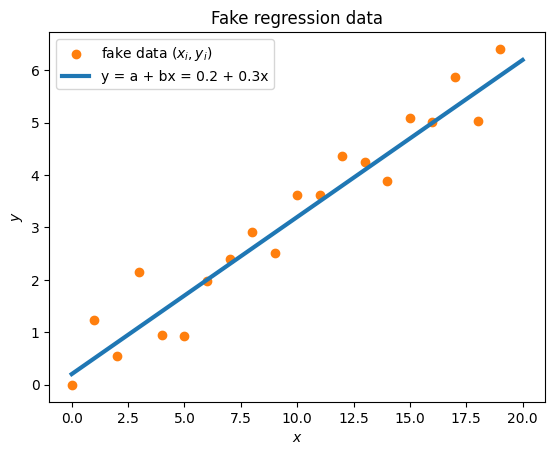

In [ ]:
a = 0.2
b = 0.3
sigma = 0.5
n = 20
x = np.arange(n)
y = a + b * x + stats.norm(0, sigma).rvs(size=n)
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot([0, 20], [a, a + b * 20], lw=3, label=f"y = a + bx = {a} + {b}x")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("Fake regression data")
plt.show()

#### Fit a `LinearRegression` model to the fake data

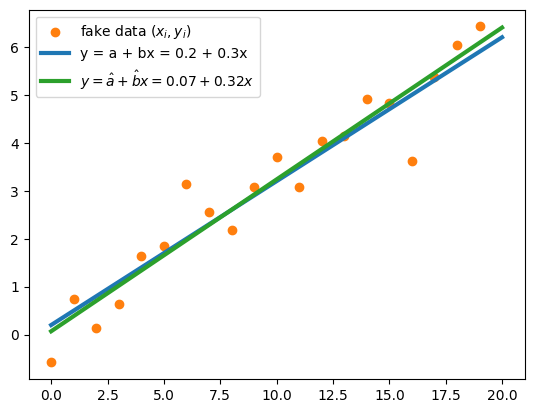

In [ ]:
model = LinearRegression()
X = x.reshape(-1, 1)
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot([0, 20], [a, a + b * 20], color="C0", lw=3, label=f"y = a + bx = {a} + {b}x")
plt.plot(
    [0, 20],
    [ahat, ahat + bhat * 20],
    color="C2",
    lw=3,
    label=f"$y = \\hat{{a}} + \\hat{{b}}x = {ahat:.2f} + {bhat:.2f}x$",
)
plt.legend()
plt.show()

#### Uncertainty in regression coefficients

- The coefficients estimates $\hat{a}$ and $\hat{b}$ are random variables.

- We can generate their distributions by replicating our simulation.

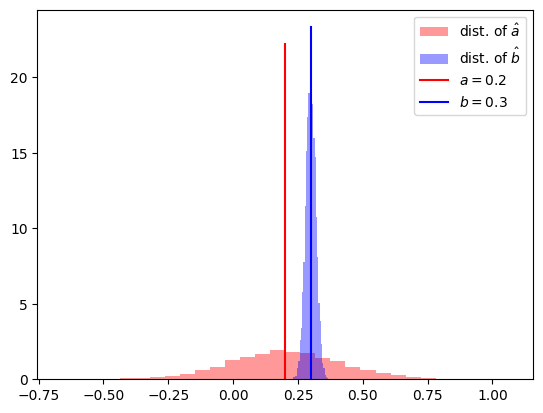

In [50]:
r = 10_000
epsilons = stats.norm(0, sigma).rvs(size=(n, r))
ys = a + b * X + epsilons
model = LinearRegression()
model.fit(X, ys)
ahats = model.intercept_
bhats = model.coef_[:, 0]
plt.hist(
    ahats, bins=30, color=(1, 0, 0, 0.4), density=True, label="dist. of $\\hat{a}$"
)
plt.hist(
    bhats, bins=30, color=(0, 0, 1, 0.4), density=True, label="dist. of $\\hat{b}$"
)
plt.plot([a, a], plt.ylim(), color=(1, 0, 0, 1), label=f"$a = {a}$")
plt.plot([b, b], plt.ylim(), color=(0, 0, 1, 1), label=f"$b = {b}$")
plt.legend()
plt.show()

- The distributions of $\hat{a}$ and $\hat{b}$ look normal because they are.

#### Residuals and estimating $\sigma$

Predicted $y$-values:
$$
\hat{y}_i = \hat{a} + \hat{b}x_i
$$

Residuals:
$$
\hat{y}_i - y_i
$$

Residual sum of squares:
$$
\operatorname{RSS} = \sum_{i < n}(\hat{y}_i - y_i)^2
$$

Estimate $\sigma^2$:
$$
s^2 = \frac{\operatorname{RSS}}{n - 2}
$$

$s$ is called the **residual standard error**.

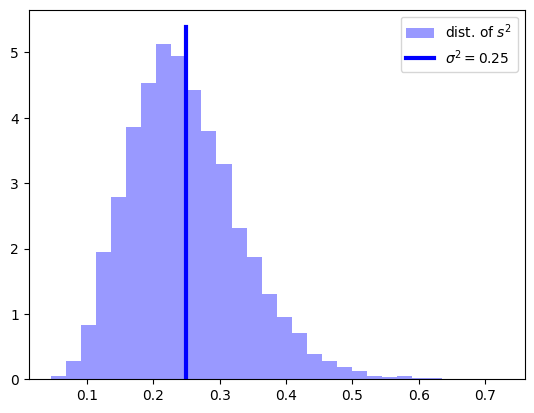

In [67]:
yhats = model.predict(X)
rsss = np.sum((yhats - ys) ** 2, axis=0)
s2s = rsss / (n - 2)
plt.hist(s2s, bins=30, density=True, color=(0, 0, 1, 0.4), label="dist. of $s^2$")
plt.plot(
    [sigma**2, sigma**2],
    plt.ylim(),
    color=(0, 0, 1),
    lw=3,
    label=f"$\\sigma^2={sigma**2}$",
)
plt.legend()
plt.show()

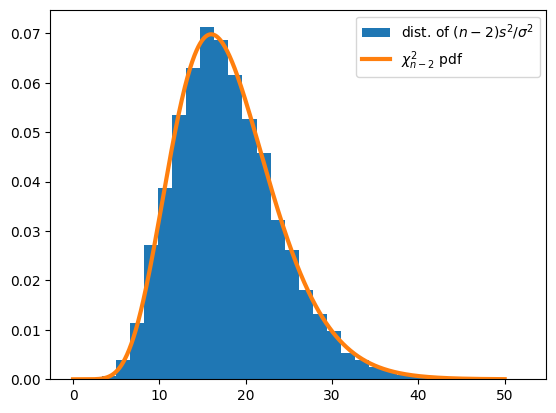

In [ ]:
plt.hist(
    (n - 2) * s2s / sigma**2,
    bins=30,
    density=True,
    label="dist. of $(n-2)s^2/\\sigma^2$",
)
mesh = np.linspace(0, 50, 1000)
plt.plot(mesh, stats.chi2(n - 2).pdf(mesh), lw=3, label="$\\chi^2_{n-2}$ pdf")
plt.legend()
plt.show()

- The `LinearRegression` class doesn't compute standard errors for coefficient estimates because `scikit-learn` doesn't concern itself with statistical inference.

***End of Lecture 4, 2025.01.20 (recorded 2025.01.18)***

***Start of Lecture 5, 2025.01.22***

### Today

- Questions from Lab 1

- Simple linear regression examples with real data (GHV &sect;6.4, 7.1)

- *Regression to the mean* and the *regression fallacy* (GHV &sect;6.5)

- Formulating comparisons as regression models (GHV &sect;7.3)

- Primary reference: GHV Chapter 7

#### Lab 1

In [9]:
# Lab warm-up exercise #2
d = stats.norm(0, 1)
print(d.cdf(1) - d.cdf(-1))
x = d.ppf(0.9)
print(d.cdf(x) - d.cdf(-x))

0.6826894921370859
0.7999999999999998


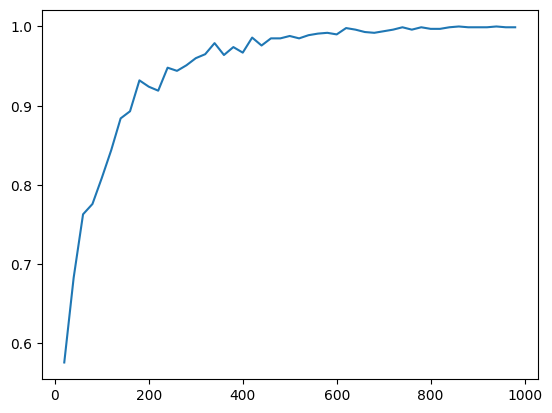

In [29]:
# GHV Exercise 4.4
m = 1000
ns = np.arange(20, 1000, 20)

correct = []
for n in ns:
    y = stats.binom(n, 0.4).rvs(size=m)
    correct.append(np.mean(y > 0.35 * n))
plt.plot(ns, correct)

In [39]:
def f(p, r, n):
    x = stats.bernoulli(r).rvs(n)
    y = stats.bernoulli(p).rvs(n)
    return x, y

### Simple linear regression examples with real data

#### Heights of mothers and daughters

In [40]:
df = pd.read_csv("../data/heights.csv")
df

,daughter_height,mother_height
0,52.5,59.5
1,52.5,59.5
2,53.5,59.5
3,53.5,59.5
4,55.5,59.5
...,...,...
5519,71.5,70.5
5520,73.5,63.5
5521,73.5,63.5
5522,73.5,63.5


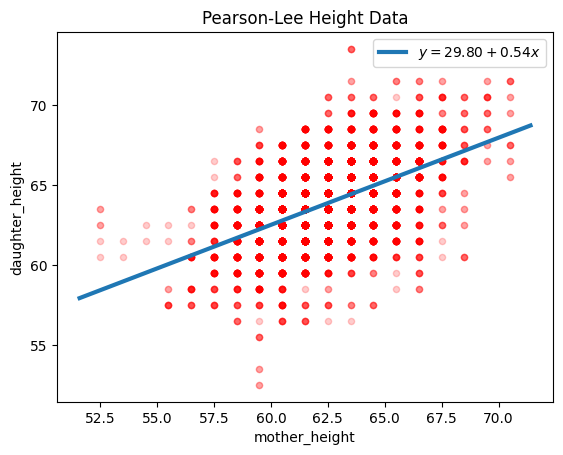

In [ ]:
df.plot.scatter("mother_height", "daughter_height", color=(1, 0, 0, 0.2))

X = df[["mother_height"]]
y = df["daughter_height"]
model = LinearRegression()
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [ahat + bhat * xmin, ahat + bhat * xmax],
    lw=3,
    label=f"$y = {ahat:.2f} + {bhat:.2f}x$",
)
plt.legend()
plt.title("Pearson-Lee Height Data")
plt.show()

- Interpreting the slope: Daughters of mothers with height $x + 1$ are, on average, $0.54$ inches taller than mother with height $x$.

- Since people can't be zero inches tall, the intercept's natural interpretation isn't particularly compelling in this example.

#### Regression to the mean

- Linear regression fit to mother/daughter height data:
$$
y - \underset{\bar{y}}{63.9} = \underset{\widehat{b}}{0.54}(x−\underset{\bar{x}}{62.5})
$$

- Daughters of tall (short) mothers tend to be taller (shorter) than average but shorter (taller) than their
mothers.

- From one generation to the next, heights "regress to the mean".

- The regression "paradox": Why doesn't the variability in height decrease over generations?

#### The regression fallacy

- interpreting regression to the mean causally.

- Examples:

   - Scoring highly on the midterm leads to overconfidence and underperforming on the final exam.

   - Negative reinforcement is more effective than positive reinforcement.

   - Sophomore slump. Sports Illustrated cover jinx. Madden curse. [More examples](https://en.wikipedia.org/wiki/Regression_toward_the_mean#Regression_fallacies).

#### Forecasting elections from the economy

> "[It's the economy, stupid!](https://en.wikipedia.org/wiki/It%27s_the_economy,_stupid)"
> James Carville, 1992

<img src="https://www.hup.harvard.edu/img/feeds/jackets/9780674027367.png" height="300px">

##### What does the model predict for the 2016 Clinton/Trump election?

- Clinton represented the incumbent Democratic party.

- Economic growth in 2016 was 2%, so $x=2$.

- Model:
$$
y\sim N(a + bx,\sigma^2)\approx N(\hat{a} + \hat{b}x, s^2)\\
$$
- Probability of Trump victory:
$$
\begin{aligned}
\mathbb{P}[y < 50] &= \operatorname{cdf}_{N(a + bx,\sigma^2)}(50)\\
&\approx \operatorname{cdf}_{N(\hat{a} + \hat{b}x, s^2)}(50)
\end{aligned}
$$